In [4]:
# load required libraries & modules
%load_ext autoreload
%autoreload 2

import os
from tqdm.notebook import tqdm
import pprint
import time
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch

from utils import *
from loaddata import *
from visualization import *
from rrcapsnet_original import *

torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False)

DATA_DIR = '../data'
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

BATCHSIZE = 1000

PATH_MNISTC = '../data/MNIST_C/'
CORRUPTION_TYPES = ['identity', 
         'shot_noise', 'impulse_noise','glass_blur','motion_blur',
         'shear', 'scale',  'rotate',  'brightness',  'translate',
         'stripe', 'fog','spatter','dotted_line', 'zigzag',
         'canny_edges']

N_MINI_PER_CORRUPTION = 1000

ACC_TYPE = "hypothesis"

# general helper funtions for model testing
def load_model(args):
    # load model
    model = RRCapsNet(args).to(args.device) 
    model.load_state_dict(torch.load(args.load_model_path))
    return model

def load_args(load_model_path, args_to_update, verbose=False):
    params_filename = os.path.dirname(load_model_path) + '/params.txt'
    assert os.path.isfile(params_filename), "No param flie exists"
    args = parse_params_wremove(params_filename, removelist = ['device']) 
    args = update_args(args, args_to_update)
    args.load_model_path = load_model_path
    if verbose:
        pprint.pprint(args.__dict__, sort_dicts=False)
    return args


@torch.no_grad()
def evaluate_on_batch(task, batchnum, model, args, train=False, verbose=True, onlyacc=False):
    
    # evaluate on one train/test batch 
    model.eval()
    
    if task == 'mnist_recon':
        # for mnist recon data, it has erased input(x) and intact input (gtx)
        if train:
            dataloader, val_dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train)
        else:
            dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train)            
        diter = iter(dataloader)
        for i in range(batchnum):
            x, gtx, y = next(diter)
    else:
        dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train)    
        diter = iter(dataloader)
        for i in range(batchnum):
            x, y = next(diter)
            gtx = None
            
            
    # attach forward hooks for intermediate outputs for visualizations
    outputs = {}
    
    # from model main output
    x_input_step = []; x_mask_step = []; objcaps_step = []
    
    # from model dynamic routing
    coups_step = []; betas_step= []; rscores_step=[]; recon_coups_step=[] 
    outcaps_len_step=[]; outcaps_len_before_step=[]

    def get_attention_outputs():
        def hook(model, input, output):
            x_mask_step.append(output[0].detach())
            x_input_step.append(output[1].detach())
        return hook

    def get_capsule_outputs():
        def hook(model, input, output):
            objcaps_step.append(output[0].detach())
            coups_step.append(torch.stack(output[1]['coups'], dim=1))
            betas_step.append(torch.stack(output[1]['betas'], dim=1)) 
            if 'rscores' in output[1].keys():
                rscores_step.append(torch.stack(output[1]['rscores'], dim=1))
            if 'recon_coups' in output[1].keys():
                recon_coups_step.append(torch.stack(output[1]['recon_coups'], dim=1))
            if 'outcaps_len' in output[1].keys():
                outcaps_len_step.append(torch.stack(output[1]['outcaps_len'], dim=1))
            if 'outcaps_len_before' in output[1].keys():
                outcaps_len_before_step.append(torch.stack(output[1]['outcaps_len_before'], dim=1))
        return hook
    

    hook1 = model.input_window.register_forward_hook(get_attention_outputs())
    hook2 = model.capsule_routing.register_forward_hook(get_capsule_outputs())
    
    # evaluate and detach hooks
    losses, acc, objcaps_len_step, x_recon_step = evaluate(model, x, y, args, acc_type=ACC_TYPE, gtx=gtx)
    hook1.remove()
    hook2.remove()
    
    # add tensor outputs dictionary
    outputs['x_input'] = torch.stack(x_input_step, dim=1)
    outputs['x_mask'] = torch.stack(x_mask_step, dim=1)
    outputs['objcaps'] = torch.stack(objcaps_step, dim=1)
    
    outputs['coups'] = torch.stack(coups_step, dim=1)
    outputs['betas'] = torch.stack(betas_step, dim=1)
    if rscores_step:
        outputs['rscores'] = torch.stack(rscores_step, dim=1)
    if recon_coups_step:
        outputs['recon_coups'] = torch.stack(recon_coups_step, dim=1)
    if outcaps_len_step:
        outputs['outcaps_len'] = torch.stack(outcaps_len_step, dim=1)
    if outcaps_len_before_step:
        outputs['outcaps_len_before'] = torch.stack(outcaps_len_before_step, dim=1)        
    if verbose:
        print("==> On this sigle test batch: test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
              % (losses[0], losses[1], losses[2], acc))
    
    if onlyacc:
        return acc
    else:
        return x, gtx, y, objcaps_len_step, x_recon_step, outputs
    
    
@torch.no_grad()
def evaluate_model_on_mnistc_mini(corruption, model, args, train=False, verbose=True, save_hooks=False, max_batch_num=None):
    
    # get corruption batch information
    corruption_id = int(CORRUPTION_TYPES.index(corruption))
    num_batch_required = int(N_MINI_PER_CORRUPTION/BATCHSIZE) # if batchsize 100; 10 batches are requried
    
    # load dataloader and iterator
    dataloader = fetch_dataloader('mnist_c_mini', DATA_DIR, DEVICE, BATCHSIZE, train)    
    diter = iter(dataloader)

    if save_hooks:
        def get_attention_outputs():
            def hook(model, input, output):
                x_mask_step.append(output[0].detach())
                x_input_step.append(output[1].detach())
            return hook

        def get_capsule_outputs():
            def hook(model, input, output):
                objcaps_step.append(output[0].detach())
                coups_step.append(torch.stack(output[1]['coups'], dim=1))
                betas_step.append(torch.stack(output[1]['betas'], dim=1)) 
                if 'rscores' in output[1].keys():
                    rscores_step.append(torch.stack(output[1]['rscores'], dim=1))
                if 'recon_coups' in output[1].keys():
                    recon_coups_step.append(torch.stack(output[1]['recon_coups'], dim=1))
                if 'outcaps_len' in output[1].keys():
                    outcaps_len_step.append(torch.stack(output[1]['outcaps_len'], dim=1))
                if 'outcaps_len_before' in output[1].keys():
                    outcaps_len_before_step.append(torch.stack(output[1]['outcaps_len_before'], dim=1))
            return hook
        
        outputs = {}

        x_input_step_all = []; x_mask_step_all = []; objcaps_step_all = []

        coups_step_all = []; betas_step_all= []; rscores_step_all=[]; recon_coups_step_all=[] 
        outcaps_len_step_all=[]; outcaps_len_before_step_all=[]

    x_all, y_all, gtx_all, loss_all, acc_all, objcaps_len_step_all, x_recon_step_all = [],[],[],[],[],[],[]
    model.eval()        
    # get input and gt
    for i in range(corruption_id*num_batch_required): #id =0, 0 iteration; id=1, 10 iteration
        x, y = next(diter)
        gtx = None
    
    for i in range(0, num_batch_required):
        x, y = next(diter)
        gtx = None
        
        if max_batch_num:
            if i == max_batch_num:
                break
            
        # for hooks over other model output
        x_input_step = []; x_mask_step = []; objcaps_step = []

        if save_hooks:

            # for hooks over dynamic routing
            coups_step = []; betas_step= []; rscores_step=[]; recon_coups_step=[] 
            outcaps_len_step=[]; outcaps_len_before_step=[]

            hook1 = model.input_window.register_forward_hook(get_attention_outputs())
            hook2 = model.capsule_routing.register_forward_hook(get_capsule_outputs())

        # evaluate and append results 
        losses, acc, objcaps_len_step, x_recon_step = evaluate(model, x, y, args, acc_type=ACC_TYPE, gtx=gtx)
        
        if verbose:
            print("==> On this sigle test batch: test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
                  % (losses[0], losses[1], losses[2], acc))   
            
        # main input and output append
        x_all.append(x)
        y_all.append(y)
        if gtx:
            gtx_all.append(gtx)
        #         loss_all.append(losses[0])
        acc_all.append(acc)
        objcaps_len_step_all.append(objcaps_len_step)
        x_recon_step_all.append(x_recon_step)
        
        if save_hooks:
        
            # hook variables append
            x_input_step_all.append(torch.stack(x_input_step, dim=1))
            x_mask_step_all.append(torch.stack(x_mask_step, dim=1))
            objcaps_step_all.append(torch.stack(objcaps_step, dim=1))

            coups_step_all.append(torch.stack(coups_step, dim=1))
            betas_step_all.append(torch.stack(betas_step, dim=1))
            if rscores_step:
                rscores_step_all.append(torch.stack(rscores_step, dim=1))
            if recon_coups_step:
                recon_coups_step_all.append(torch.stack(recon_coups_step, dim=1))
            if outcaps_len_step:
                outcaps_len_step_all.append(torch.stack(outcaps_len_step, dim=1))
            if outcaps_len_before_step:
                outcaps_len_before_step_all.append(torch.stack(outcaps_len_before_step, dim=1))

            hook1.remove()
            hook2.remove()
    
        
    # concat and add to outputs dictionary
    x_all = torch.cat(x_all, dim=0)
    y_all = torch.cat(y_all, dim=0)
    if gtx:
        gtx_all = torch.cat(gtx_all, dim=0)
    else:
        gtx_all = gtx
    acc_all = torch.cat(acc_all, dim=0)
    objcaps_len_step_all = torch.cat(objcaps_len_step_all, dim=0)
    x_recon_step_all = torch.cat(x_recon_step_all, dim=0)
    
    if save_hooks:
        outputs['x_input']= torch.cat(x_input_step_all, dim=0)
        outputs['x_mask']= torch.cat(x_mask_step_all, dim=0)
        outputs['objcaps']= torch.cat(objcaps_step_all, dim=0)

        outputs['coups'] = torch.cat(coups_step_all, dim=0)
        outputs['betas'] = torch.cat(betas_step_all, dim=0)
        if rscores_step_all:
            outputs['rscores'] = torch.cat(rscores_step_all, dim=0)
        if recon_coups_step_all:
            outputs['recon_coups'] = torch.cat(recon_coups_step_all, dim=0)
        if outcaps_len_step_all:
            outputs['outcaps_len'] = torch.cat(outcaps_len_step_all, dim=0)
        if outcaps_len_before_step_all:
            outputs['outcaps_len_before'] = torch.cat(outcaps_len_before_step_all, dim=0)
            
        return x_all, gtx_all, y_all, acc_all, objcaps_len_step_all, x_recon_step_all, outputs  

    else:
        return x_all, gtx_all, y_all, acc_all, objcaps_len_step_all, x_recon_step_all
    
    
@torch.no_grad()
def evaluate_cnn_on_mnistc_mini(corruption, cnn, max_batch_num=None):
    # get corruption batch information
    corruption_id = int(CORRUPTION_TYPES.index(corruption))
    num_batch_required = int(N_MINI_PER_CORRUPTION/BATCHSIZE) # if batchsize 100; 10 batches are requried
    
    # load dataloader and iterator
    dataloader = fetch_dataloader('mnist_c_mini', DATA_DIR, DEVICE, BATCHSIZE, train=False)    
    diter = iter(dataloader)
    
    # save output
    x_all, y_all, pred_all, acc_all, class_prob_all = [],[],[], [],[]
    cnn.eval() 

    # get input and gt
    for i in range(corruption_id*num_batch_required): #id =0, 0 iteration; id=1, 10 iteration
        x, y = next(diter)
    

    for i in range(0, num_batch_required):
        x, y = next(diter)
        gtx = None
        
        if max_batch_num:
            if i == max_batch_num:
                break
        
        data, target = x.to(DEVICE),  y.to(DEVICE)
        target = target.argmax(dim=1, keepdim=True)
        output = cnn(data)
        #                 test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        acc = pred.eq(target.view_as(pred))
        
        x_all.append(data)
        y_all.append(target.flatten())
        pred_all.append(pred.flatten())
        acc_all.append(acc.flatten().float())
        class_prob_all.append(output)
    

    # concat and add to outputs dictionary
    x_all = torch.cat(x_all, dim=0)
    y_all = torch.cat(y_all, dim=0)
    pred_all = torch.cat(pred_all, dim=0)
    acc_all = torch.cat(acc_all, dim=0)
    class_prob_all = torch.cat(class_prob_all, dim=0)

    return x_all, y_all, class_prob_all, pred_all, acc_all
    
@torch.no_grad()
def evaluate_model_on_mnistc_original(corruption, model, verbose=False, save_hooks=False,  max_batch_num=None):
    path_images = os.path.join(PATH_MNISTC, corruption, 'test_images.npy')
    path_labels = os.path.join(PATH_MNISTC, corruption, 'test_labels.npy')

    # convert to torch
    images = np.load(path_images)
    labels = np.load(path_labels)
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    # print(images_tensorized.shape) #torch.Size([10000, 1, 28, 28])
    # print(labels_tensorized.shape) #torch.Size([10000, 10])

    # create dataloader
    kwargs = {'num_workers': 1, 'pin_memory': True} if DEVICE == 'cuda' else {}
    dataset = TensorDataset(images_tensorized, labels_tensorized)
    dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=False, drop_last=False, **kwargs)

    if save_hooks:
        def get_attention_outputs():
            def hook(model, input, output):
                x_mask_step.append(output[0].detach())
                x_input_step.append(output[1].detach())
            return hook

        def get_capsule_outputs():
            def hook(model, input, output):
                objcaps_step.append(output[0].detach())
                coups_step.append(torch.stack(output[1]['coups'], dim=1))
                betas_step.append(torch.stack(output[1]['betas'], dim=1)) 
                if 'rscores' in output[1].keys():
                    rscores_step.append(torch.stack(output[1]['rscores'], dim=1))
                if 'recon_coups' in output[1].keys():
                    recon_coups_step.append(torch.stack(output[1]['recon_coups'], dim=1))
                if 'outcaps_len' in output[1].keys():
                    outcaps_len_step.append(torch.stack(output[1]['outcaps_len'], dim=1))
                if 'outcaps_len_before' in output[1].keys():
                    outcaps_len_before_step.append(torch.stack(output[1]['outcaps_len_before'], dim=1))
            return hook
        
        outputs = {}

        x_input_step_all = []; x_mask_step_all = []; objcaps_step_all = []

        coups_step_all = []; betas_step_all= []; rscores_step_all=[]; recon_coups_step_all=[] 
        outcaps_len_step_all=[]; outcaps_len_before_step_all=[]

    x_all, y_all, gtx_all, loss_all, acc_all, objcaps_len_step_all, x_recon_step_all = [],[],[],[],[],[],[]
    
    model.eval()      
    
    # get input and gt
    i=0
    for data in dataloader:
        
#         if max_batch_num:
#             if i == max_batch_num:
#                 break
        if i == max_batch_num:
            x, y = data
            gtx = None

            # for hooks over other model output
            x_input_step = []; x_mask_step = []; objcaps_step = []

            if save_hooks:

                # for hooks over dynamic routing
                coups_step = []; betas_step= []; rscores_step=[]; recon_coups_step=[] 
                outcaps_len_step=[]; outcaps_len_before_step=[]

                hook1 = model.input_window.register_forward_hook(get_attention_outputs())
                hook2 = model.capsule_routing.register_forward_hook(get_capsule_outputs())

            # evaluate and append results 
            losses, acc, objcaps_len_step, x_recon_step = evaluate(model, x, y, args, acc_type=ACC_TYPE, gtx=gtx)

            if verbose:
                print("==> On this sigle test batch: test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
                      % (losses[0], losses[1], losses[2], acc))   

            # main input and output append
            x_all.append(x)
            y_all.append(y)
            if gtx:
                gtx_all.append(gtx)
            #         loss_all.append(losses[0])
            acc_all.append(acc)
            objcaps_len_step_all.append(objcaps_len_step)
            x_recon_step_all.append(x_recon_step)

            if save_hooks:

                # hook variables append
                x_input_step_all.append(torch.stack(x_input_step, dim=1))
                x_mask_step_all.append(torch.stack(x_mask_step, dim=1))
                objcaps_step_all.append(torch.stack(objcaps_step, dim=1))

                coups_step_all.append(torch.stack(coups_step, dim=1))
                betas_step_all.append(torch.stack(betas_step, dim=1))
                if rscores_step:
                    rscores_step_all.append(torch.stack(rscores_step, dim=1))
                if recon_coups_step:
                    recon_coups_step_all.append(torch.stack(recon_coups_step, dim=1))
                if outcaps_len_step:
                    outcaps_len_step_all.append(torch.stack(outcaps_len_step, dim=1))
                if outcaps_len_before_step:
                    outcaps_len_before_step_all.append(torch.stack(outcaps_len_before_step, dim=1))

                hook1.remove()
                hook2.remove()        
        
        
        i+=1
        

    
        
    # concat and add to outputs dictionary
    x_all = torch.cat(x_all, dim=0)
    y_all = torch.cat(y_all, dim=0)
    if gtx:
        gtx_all = torch.cat(gtx_all, dim=0)
    else:
        gtx_all = gtx
    acc_all = torch.cat(acc_all, dim=0)
    objcaps_len_step_all = torch.cat(objcaps_len_step_all, dim=0)
    x_recon_step_all = torch.cat(x_recon_step_all, dim=0)
    
    if save_hooks:
        outputs['x_input']= torch.cat(x_input_step_all, dim=0)
        outputs['x_mask']= torch.cat(x_mask_step_all, dim=0)
        outputs['objcaps']= torch.cat(objcaps_step_all, dim=0)

        outputs['coups'] = torch.cat(coups_step_all, dim=0)
        outputs['betas'] = torch.cat(betas_step_all, dim=0)
        if rscores_step_all:
            outputs['rscores'] = torch.cat(rscores_step_all, dim=0)
        if recon_coups_step_all:
            outputs['recon_coups'] = torch.cat(recon_coups_step_all, dim=0)
        if outcaps_len_step_all:
            outputs['outcaps_len'] = torch.cat(outcaps_len_step_all, dim=0)
        if outcaps_len_before_step_all:
            outputs['outcaps_len_before'] = torch.cat(outcaps_len_before_step_all, dim=0)
            
        return x_all, gtx_all, y_all, acc_all, objcaps_len_step_all, x_recon_step_all, outputs  

    else:
        return x_all, gtx_all, y_all, acc_all, objcaps_len_step_all, x_recon_step_all
    
    

@torch.no_grad()
def evaluate_cnn_on_mnistc_original(corruption, cnn, max_batch_num=None):
    path_images = os.path.join(PATH_MNISTC, corruption, 'test_images.npy')
    path_labels = os.path.join(PATH_MNISTC, corruption, 'test_labels.npy')

    # convert to torch
    images = np.load(path_images)
    labels = np.load(path_labels)
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    # print(images_tensorized.shape) #torch.Size([10000, 1, 28, 28])
    # print(labels_tensorized.shape) #torch.Size([10000, 10])

    # create dataloader
    kwargs = {'num_workers': 1, 'pin_memory': True} if DEVICE == 'cuda' else {}
    dataset = TensorDataset(images_tensorized, labels_tensorized)
    dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=False, drop_last=False, **kwargs)

    # save output
    x_all, y_all, pred_all, acc_all, class_prob_all = [],[],[], [],[]
    cnn.eval() 

    # get input and gt
    i=0
    for data in dataloader:
        
#         if max_batch_num:
#             if i == max_batch_num:
#                 break

        if i == max_batch_num:
            x, y = data
            gtx = None
                    
            data, target = x.to(DEVICE),  y.to(DEVICE)
            target = target.argmax(dim=1, keepdim=True)
            output = cnn(data)
            #                 test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            acc = pred.eq(target.view_as(pred))

            x_all.append(data)
            y_all.append(target.flatten())
            pred_all.append(pred.flatten())
            acc_all.append(acc.flatten().float())
            class_prob_all.append(output)
        
        i+=1


    # concat and add to outputs dictionary
    x_all = torch.cat(x_all, dim=0)
    y_all = torch.cat(y_all, dim=0)
    pred_all = torch.cat(pred_all, dim=0)
    acc_all = torch.cat(acc_all, dim=0)
    class_prob_all = torch.cat(class_prob_all, dim=0)

    return x_all, y_all, class_prob_all, pred_all, acc_all

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Evaluate on batch

In [3]:
##################
# model comparison on a single batch 
# (if tested on mnist_c_mini, all different corruption type batches are tested)
##################
task='mnist_occlusion'
task='mnist_recon'
task='mnist_c_mini'
train=False #train or test dataset
print_args=False
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 
                 'time_steps': 4, 'routings':3 , 'mask_threshold': 0.1}

modellist = [

# original rrcapsnet (mnist_recon, trainvalsplit)
# './models/rrcapsnet/run1_epoch50_acc0.9917.pt',
# './models/rrcapsnet/run2_epoch50_acc0.9915.pt',
# './models/rrcapsnet/run3_epoch50_acc0.9907.pt',
# './models/rrcapsnet/run4_epoch50_acc0.9905.pt',
# './models/rrcapsnet/run5_epoch50_acc0.9907.pt',

# './results/mnist/Apr28_1815_capsnetencoder_cycle/archive_model_epoch220_acc0.9961.pt'
# './results/mnist/Apr28_1815_capsnetencoder_cycle/archive_model_epoch390_acc0.9992.pt'
# './results/mnist/Apr28_2001_shift_adamclr/archive_model_epoch50_acc0.9860.pt'
# './results/mnist/Apr28_2055_shift_adamclr_epoch1000/best_model_epoch147_acc0.9885.pt'
# './results/mnist/Apr28_2131_shift_adamclr_epoch1000_difflrrange/archive_model_epoch80_acc0.9979.pt'
# './results/mnist/Apr29_0120_test/archive_epoch50_acc0.9975.pt'

# clean-wd
# './results/mnist/Apr29_0213_clean_wd_run1/best_epoch75_acc0.9981.pt',

# best our
# './models/rrcapsnet/rrcapsnet_best.pt'
    
# clean-aug
# './results/mnist/May25_0411_clean_aug_run3/best_epoch99_acc0.9713.pt'
    
# recon edge
# './results/mnist/May25_2049_recon_edge_run1/best_epoch68_acc0.9980.pt'
# './results/mnist/May25_2111_recon_edge_run2/best_epoch66_acc0.9986.pt'
# './results/mnist/May25_2156_train_edge_run1/archive_epoch70_acc0.9955.pt'    
# './results/mnist/May25_2219_train_edge_run2/best_epoch39_acc0.9970.pt'
# './results/mnist/May25_2131_recon_edge_run3/best_epoch70_acc0.9987.pt'
# blur-resnet
# './results/mnist/May26_0133_test/best_epoch51_acc0.9999.pt'
# './results/mnist/May27_0156_test2/best_epoch33_acc0.9999.pt'
# './results/mnist/May28_2148_test3/best_epoch19_acc1.0000.pt'
# './results/mnist/May28_2152_test-same/best_epoch17_acc1.0000.pt'
# './results/mnist/May29_0142_test4/best_epoch21_acc1.0000.pt'
# './results/mnist/May29_0220_test5-32/best_epoch26_acc1.0000.pt'
# './results/mnist/May29_0210_test5/best_epoch23_acc1.0000.pt'
# './results/mnist/May29_1445_test4-32/best_epoch29_acc1.0000.pt'
# './results/mnist/May29_1525_test6/best_epoch32_acc1.0000.pt'
# './results/mnist/May29_1543_test6-64/best_epoch38_acc1.0000.pt'
# './results/mnist/May29_2031_test7/best_epoch29_acc1.0000.pt'

'./results/mnist/May29_2045_blur_res4_run1/best_epoch32_acc1.0000.pt',

]

df = pd.DataFrame()
for i, load_model_path in enumerate(modellist):
    
    # load model
    args = load_args(load_model_path, args_to_update, print_args)
    model = load_model(args)
    print(f'model is loaded from {load_model_path}')

    if task=='mnist_c_mini':
        df['corruption'] = CORRUPTION_TYPES
        accs = []
        for corruption in CORRUPTION_TYPES:
            x, gtx, y, acc_all, objcaps_len_step, x_recon_step = \
            evaluate_model_on_mnistc_mini(corruption, model, args, train, verbose=False, save_hooks=False)
            accs.append(acc_all.mean().item())
            

            
    else:
        accs = evaluate_on_batch(task, 1, model, args, train, verbose=False, onlyacc=True)

    df[f'model{i+1}'] =accs

df.index = np.arange(1, len(df)+1)
df.loc['AVERAGE'] = df.mean()

df




=========== model instantiated like below: =============
TASK: mnist_recon (# targets: 1, # classes: 10, # background: 0)
TIMESTEPS #: 4
ENCODER: resnet w/ None projection
...resulting primary caps #: 288, dim: 8
ROUTINGS # 3
Object #: 10, BG Capsule #: 0
DECODER: fcn, w/ None projection
...recon only one object capsule: True
...use recon mask for attention: True
...with mask type bool, threshold 0.1, apply_method match

model is loaded from ./results/mnist/May29_2045_blur_res4_run1/best_epoch32_acc1.0000.pt


/tmp/ipykernel_80129/180847382.py:85: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.loc['AVERAGE'] = df.mean()


,corruption,model1
1,identity,0.992000
2,shot_noise,0.970000
3,impulse_noise,0.949000
4,glass_blur,0.948000
5,motion_blur,0.967000
6,shear,0.985000
7,scale,0.959000
8,rotate,0.935000
9,brightness,0.993000
10,translate,0.602000


# Visualize individual, stepwise sample output

In [5]:
#############################
# test a single model, and visualize outputs
#############################
task='mnist_c_mini'
task='mnist_recon'
task='mnist_c_original'

train=False #train or test dataset
print_args=False

# load model 
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 
                 'time_steps': 4, 'routings': 3, 'mask_threshold': 0.1}

load_model_path = './models/rrcapsnet/rrcapsnet_best.pt'
load_model_path = './results/mnist/May25_2049_recon_edge_run1/best_epoch68_acc0.9980.pt'
load_model_path= './results/mnist/May25_2131_recon_edge_run3/best_epoch70_acc0.9987.pt'

load_model_path = './results/mnist/May29_2045_blur_res4_run1/best_epoch32_acc1.0000.pt'

args = load_args(load_model_path, args_to_update, print_args)
model = load_model(args)


# obtain model prediction and outputs
corruption_index =12
corruption =CORRUPTION_TYPES[corruption_index-1]

if task == 'mnist_c_mini':
    x, gtx, y_hot, acc_model, objcaps_len_step, x_recon_step, outputs_model  = \
    evaluate_model_on_mnistc_mini(corruption, model, args, train, verbose=False, save_hooks=True, max_batch_num=None)
    print(f'==> corruption type: {corruption}, this batch acc: {acc_model.mean().item()}')
elif task =='mnist_c_original':
    print("original is used")
    batchnum=0
    x, gtx, y_hot, acc_model, objcaps_len_step, x_recon_step, outputs_model = \
    evaluate_model_on_mnistc_original(corruption, model, verbose=False, save_hooks=True, max_batch_num=batchnum)
    print(f'==> corruption type: {corruption}, this batch acc: {acc_model.mean().item()}')
else:
#     batchnum=corruption_index*int(1000/BATCHSIZE)-1
    x, gtx, y, objcaps_len_step, x_recon_step, outputs_model = evaluate_on_batch(task, 1, model, args, train)

# get model prediction
objcaps_len_step_narrow = objcaps_len_step.narrow(dim=2,start=0, length=args.num_classes)
# pred_model = objcaps_len_step_narrow.max(dim=-1)[1][:,-1] #torch.Size([1000, 3])


def get_nstep(objcaps_len_step_narrow, y_hot):
    def get_first_zero_index(x, axis=1):
        cond = (x == 0)
        return ((cond.cumsum(axis) == 1) & cond).max(axis, keepdim=True)[1]

    pstep = objcaps_len_step_narrow.max(dim=-1)[1]
    pnow = pstep[:,1:]
    pbefore = pstep[:,:-1]

    pdiff = (pnow-pbefore)
    null_column = -99*torch.ones(pdiff.size(0),1).to(pdiff.device)
    pdiff = torch.cat([null_column, pdiff], dim=1)
    pdiff[:,-1]=0
    nstep = get_first_zero_index(pdiff)
    pred_model= torch.gather(pstep, 1, nstep).flatten()
    acc_model = torch.eq(pred_model.cpu(), y_hot.max(dim=1)[1])
    return (nstep.flatten()+1).cpu().numpy(), pred_model, acc_model

nstep, pred_model, acc_model_check = get_nstep(objcaps_len_step_narrow, y_hot)
assert round(acc_model.mean().item(), 4) == round(acc_model_check.float().mean().item(), 4)


=========== model instantiated like below: =============
TASK: mnist_recon (# targets: 1, # classes: 10, # background: 0)
TIMESTEPS #: 4
ENCODER: resnet w/ None projection
...resulting primary caps #: 288, dim: 8
ROUTINGS # 3
Object #: 10, BG Capsule #: 0
DECODER: fcn, w/ None projection
...recon only one object capsule: True
...use recon mask for attention: True
...with mask type bool, threshold 0.1, apply_method match

original is used
==> corruption type: fog, this batch acc: 0.9500000476837158


In [6]:
############################################
# if compare with cnn results
############################################
from train_cnn import Net

path_cnn = './models/cnn/cnn_best.pt'

cnn = Net().to(DEVICE)
cnn.load_state_dict(torch.load(path_cnn))
cnn.eval()
if task == 'mnist_c_mini':
    data_cnn, target_cnn, logsoft_cnn, pred_cnn, acc_cnn \
    = evaluate_cnn_on_mnistc_mini(corruption, cnn, max_batch_num=None)
    print(f'==> corruption type: {corruption}, this batch acc: {acc_cnn.float().mean().item()}')
elif task =='mnist_c_original':
    print("original is used")
    data_cnn, target_cnn, logsoft_cnn, pred_cnn, acc_cnn \
    =  evaluate_cnn_on_mnistc_original(corruption, cnn,  max_batch_num=batchnum)
    print(f'==> corruption type: {corruption}, this batch acc: {acc_cnn.float().mean().item()}')
    
#######################
# get trials id where both model fails & disagree
#######################
assert (target_cnn.cpu() == y_hot.max(dim=1)[1].cpu()).all()
bool_bothincorrect = ~(acc_model.bool())* ~(acc_cnn.bool())
bool_diffanswer = (pred_model!= pred_cnn)
bool_onlycnncorrect = ~(acc_model.bool())* (acc_cnn.bool())
# idx_bothincorrect = torch.nonzero(bool_bothincorrect)
trialid_to_visualize = torch.nonzero(bool_bothincorrect*bool_diffanswer).flatten().tolist()
# trialid_to_visualize = torch.nonzero(bool_onlycnncorrect*bool_diffanswer).flatten().tolist()

print(len(trialid_to_visualize))

original is used
==> corruption type: fog, this batch acc: 0.8140000104904175
10




================ TRIAL 329 ===================


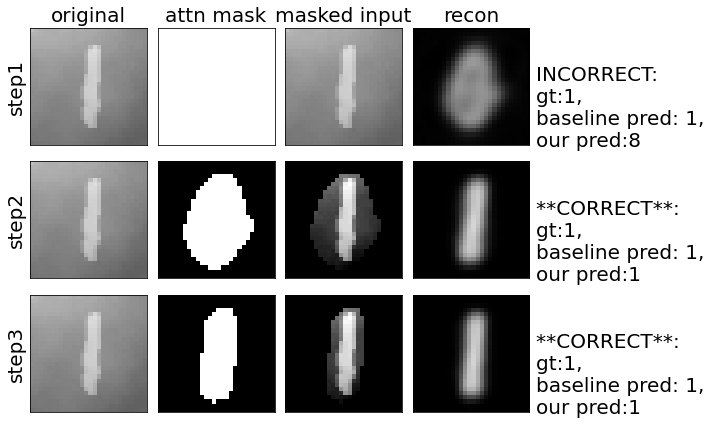

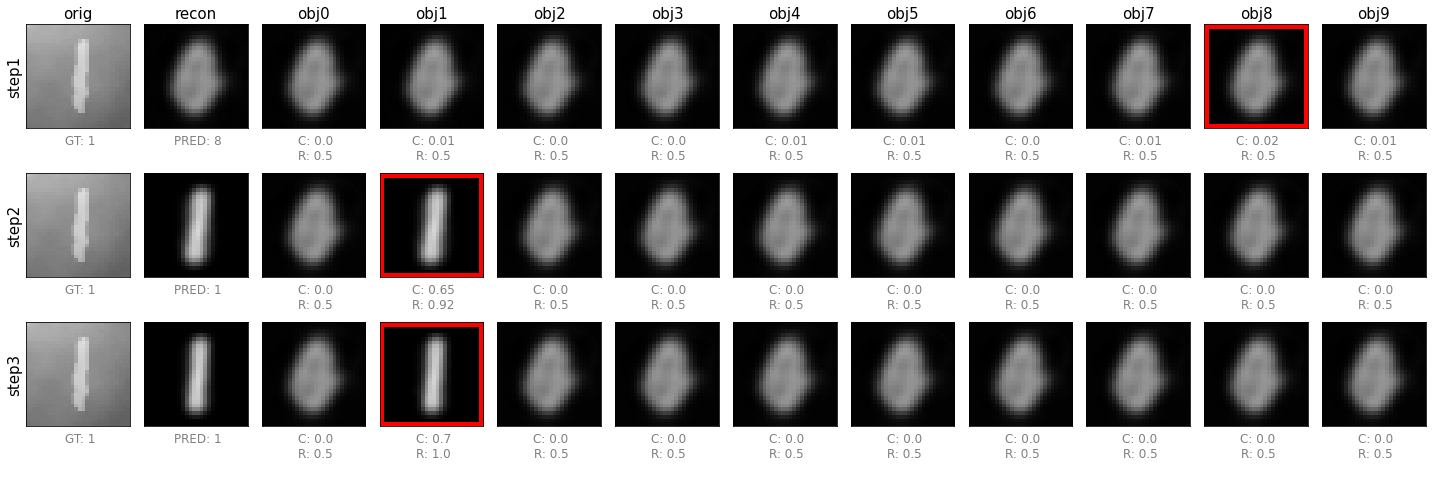

coupling coeff at time step:  1
self.rc===


/home/exx/Workspace/rrcapsnet-public/visualization_original.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[n,1].set_yticklabels(objlabels)
/home/exx/Workspace/rrcapsnet-public/visualization_original.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[n,2].set_yticklabels(objlabels)
/home/exx/Workspace/rrcapsnet-public/visualization_original.py:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[n,3].set_yticklabels(objlabels)


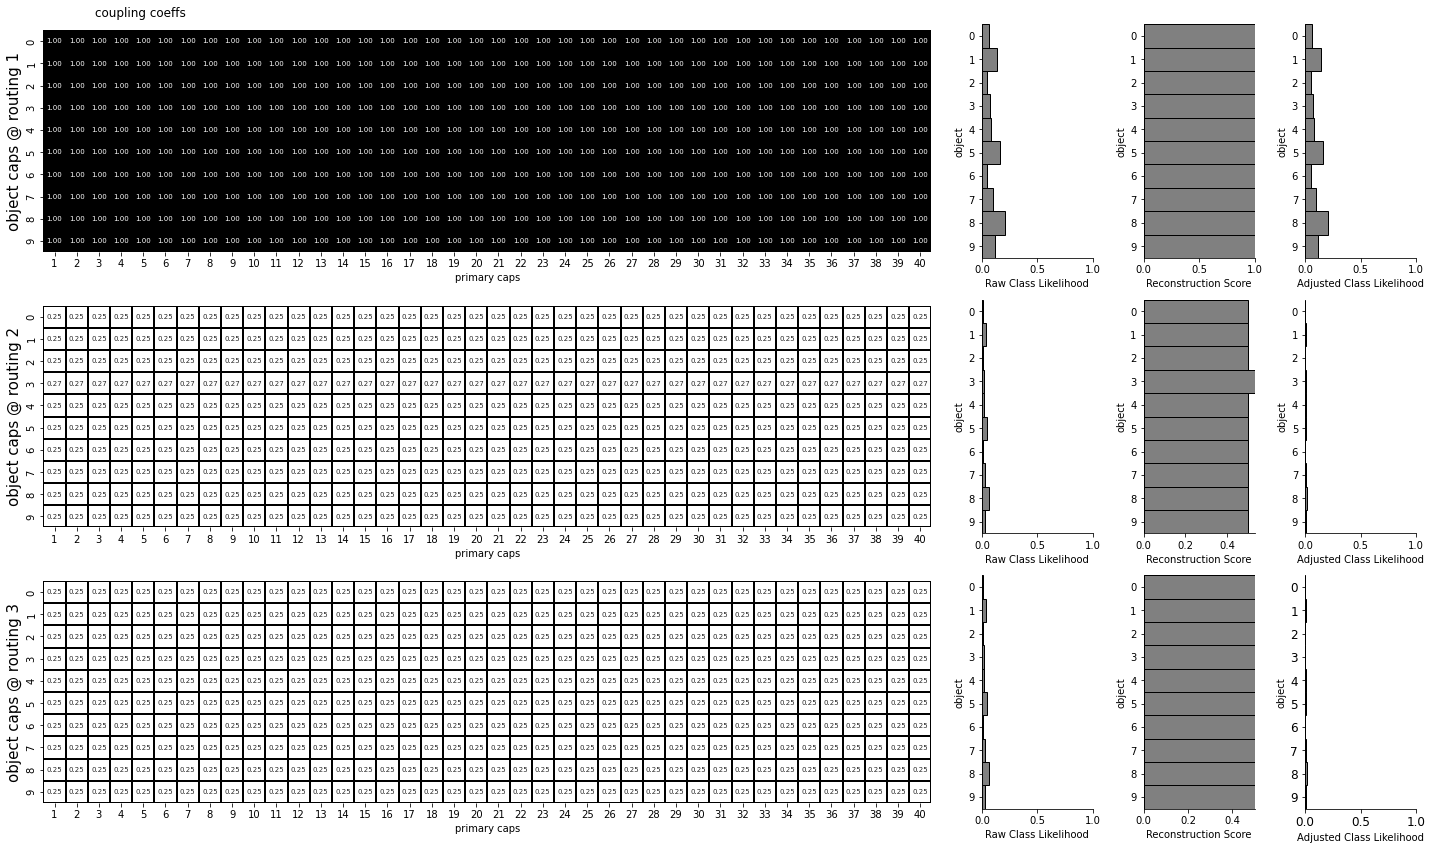

coupling coeff at time step:  2
self.rc===


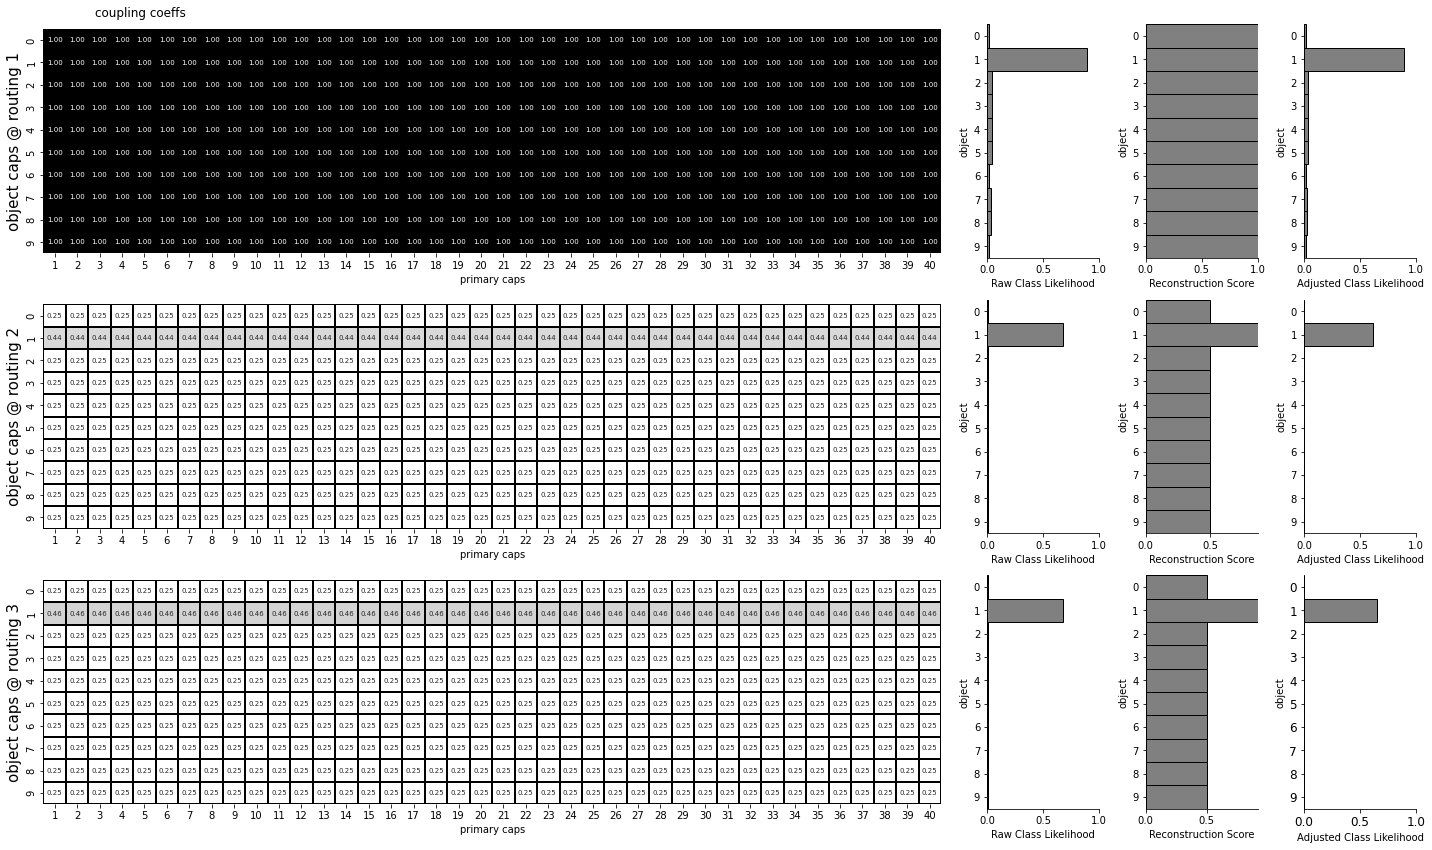

coupling coeff at time step:  3
self.rc===


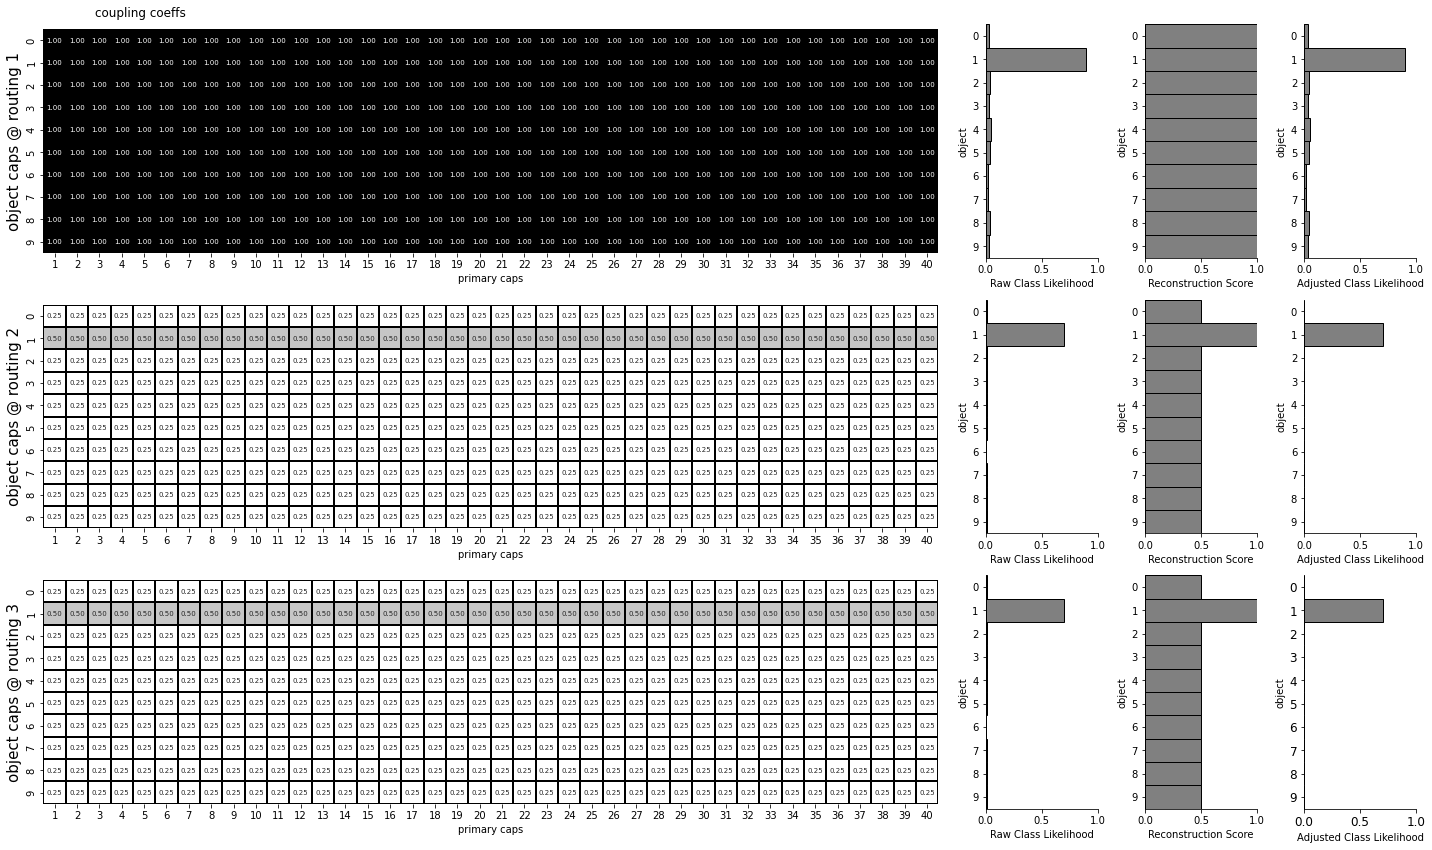



================ TRIAL 336 ===================


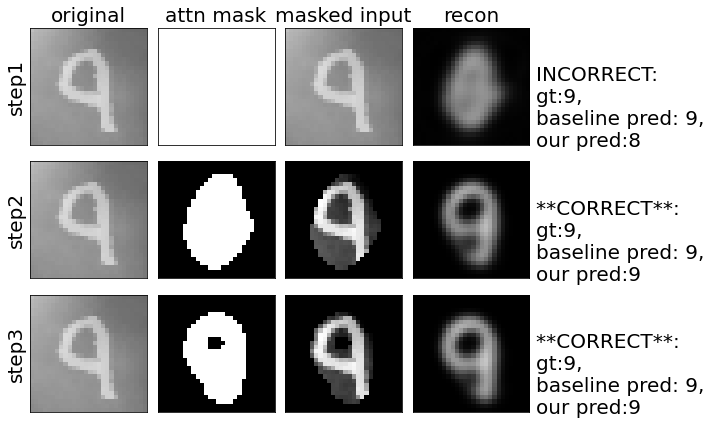

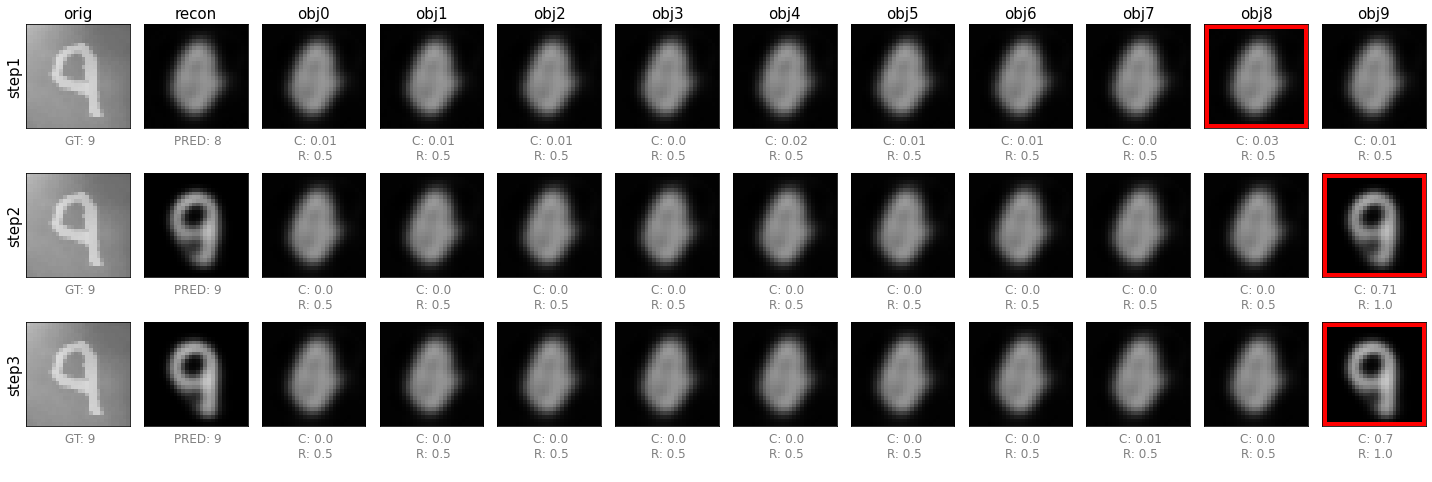

coupling coeff at time step:  1
self.rc===



KeyboardInterrupt



In [7]:
# no routing
###################################
# stepwise visualization
###################################
idx_start = 0 # can't be higher than batchsize
n_image =500

condition = 'first correct last incorrect'
condition = 'first incorrect last correct'
# condition = 'first incorrect last incorrect'
condition = 'all'
condition = 'correct'
condition = 'incorrect' 

# condition = [6, 41, 66]
# condition = [7, 11]
# condition = [66, 114, 656] #batchnum1
# condition = [6] #batchnum2
# condition = [6] #batchnum3
# condition = [17]
# condition = [8] #batchnum 3
# condition = [22, 33,41,44,75,82,88,147] #fog batch
# condition = [6,7]
# condition = [17]
# condition = [447]
# condition = [167, 502, 1466]

# condition = trialid_to_visualize #[:20]
# condition = list(np.where(nstep==3)[0])
# condition = [309]
# condition = [560, 893]
# condition=[7]
# condition=[82, 92]

condition = [329,336]
idx_plotted =\
visualize_detail(model, x.to(DEVICE), y_hot, outputs_model, 
                 x_recon_step, objcaps_len_step, args,
                 start=idx_start, n_image=n_image, plot_trials_when = condition,
                 plot_routings=True, 
                 pred_to_compare=pred_cnn, num_steps_to_finish=list(nstep), 
                 only_plot_object=None)


=========== model instantiated like below: =============
TASK: mnist_recon (# targets: 1, # classes: 10, # background: 0)
TIMESTEPS #: 4
ENCODER: resnet w/ None projection
...resulting primary caps #: 288, dim: 8
ROUTINGS # 3
Object #: 10, BG Capsule #: 0
DECODER: fcn, w/ None projection
...recon only one object capsule: True
...use recon mask for attention: True
...with mask type bool, threshold 0.1, apply_method match

original is used
==> corruption type: fog, this batch acc: 0.9550000429153442


================ TRIAL 329 ===================


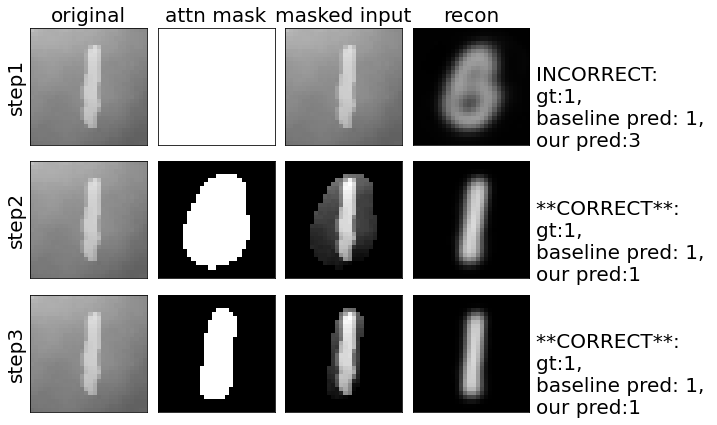

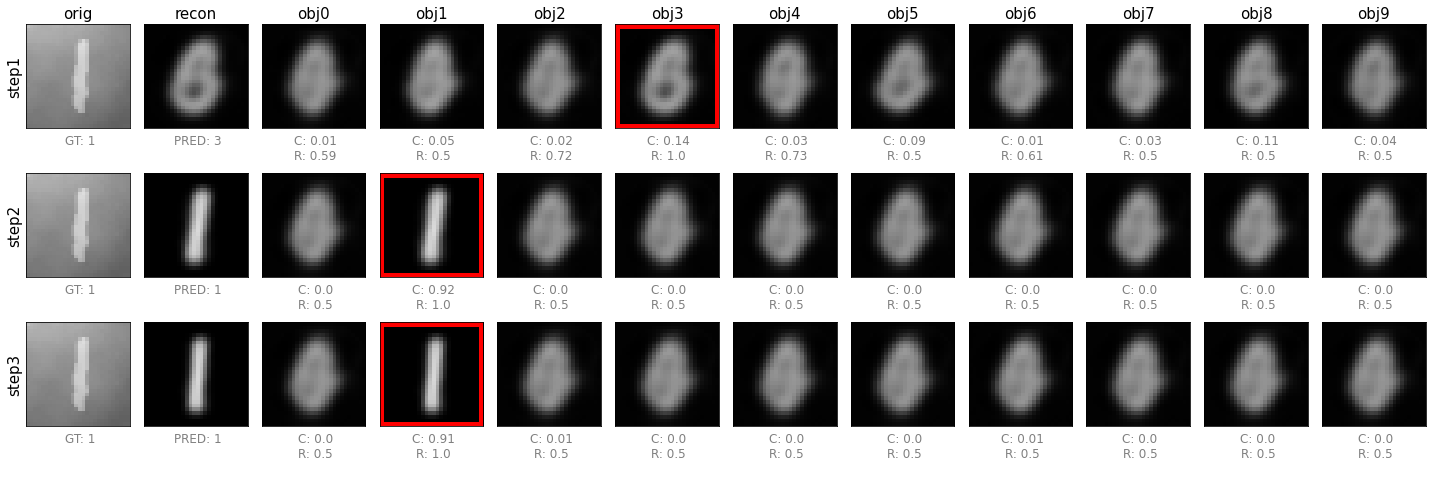

coupling coeff at time step:  1
self.rc===


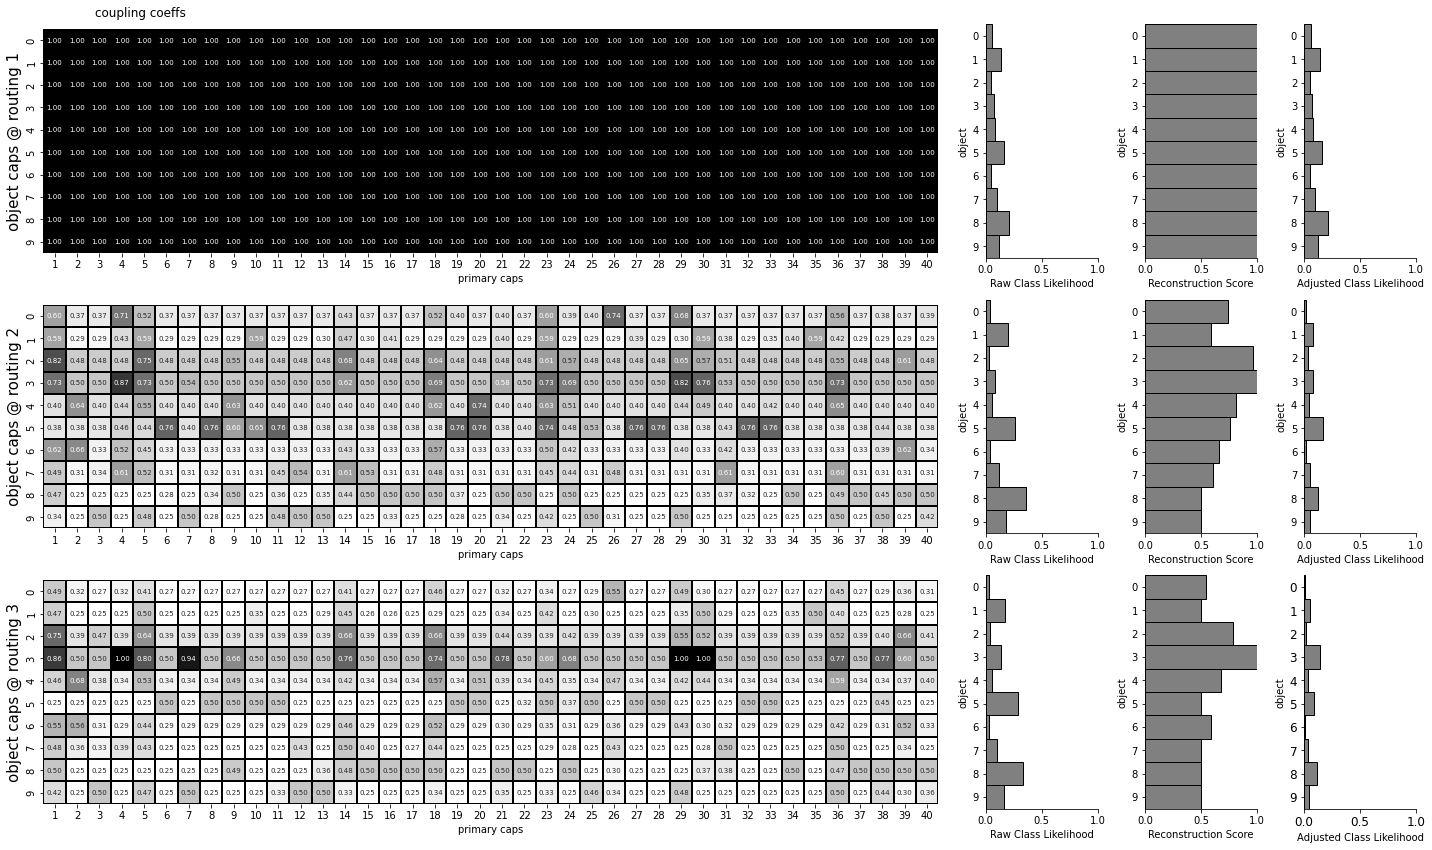

coupling coeff at time step:  2
self.rc===


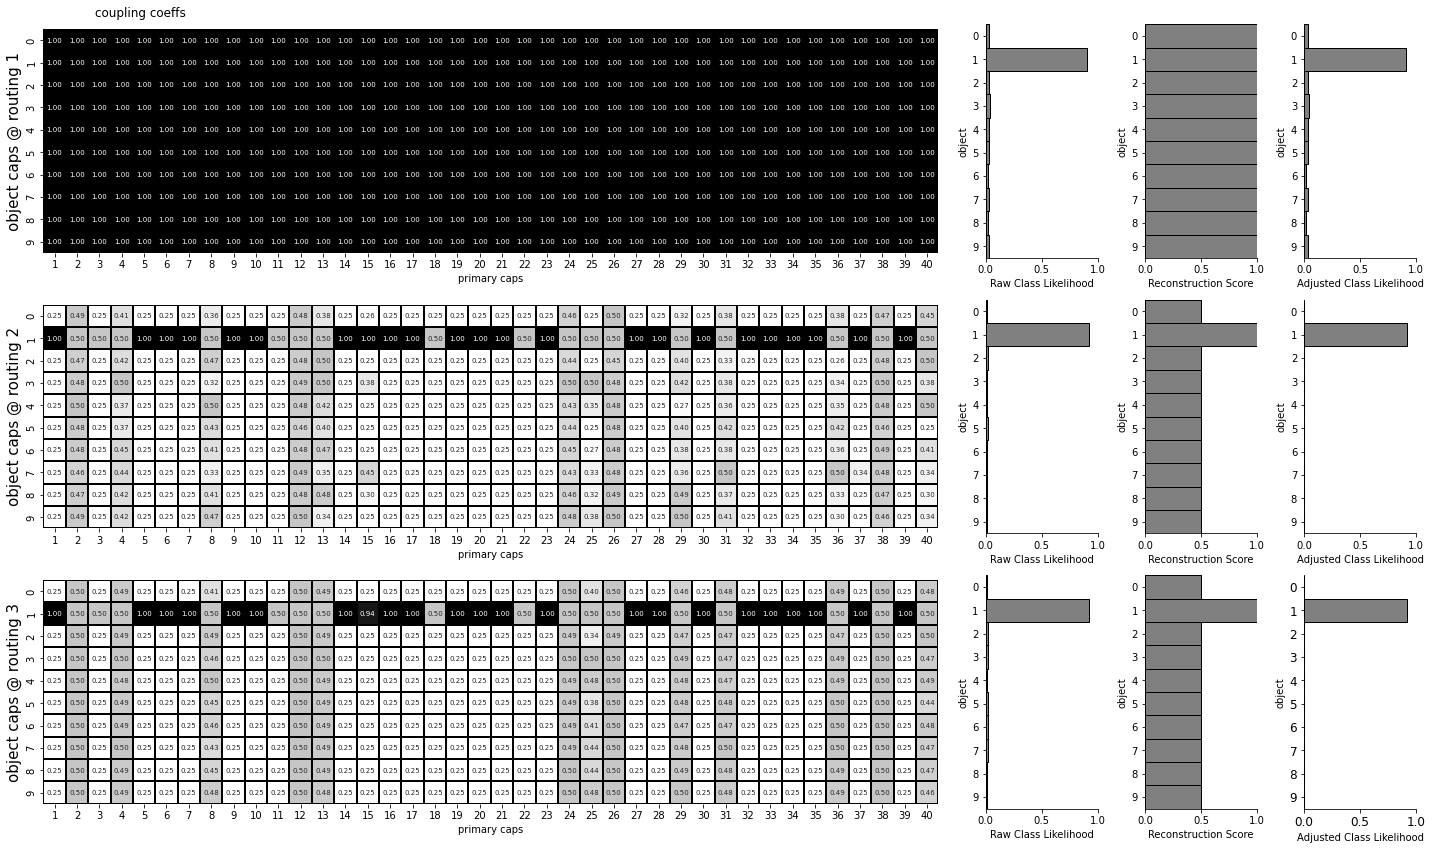

coupling coeff at time step:  3
self.rc===


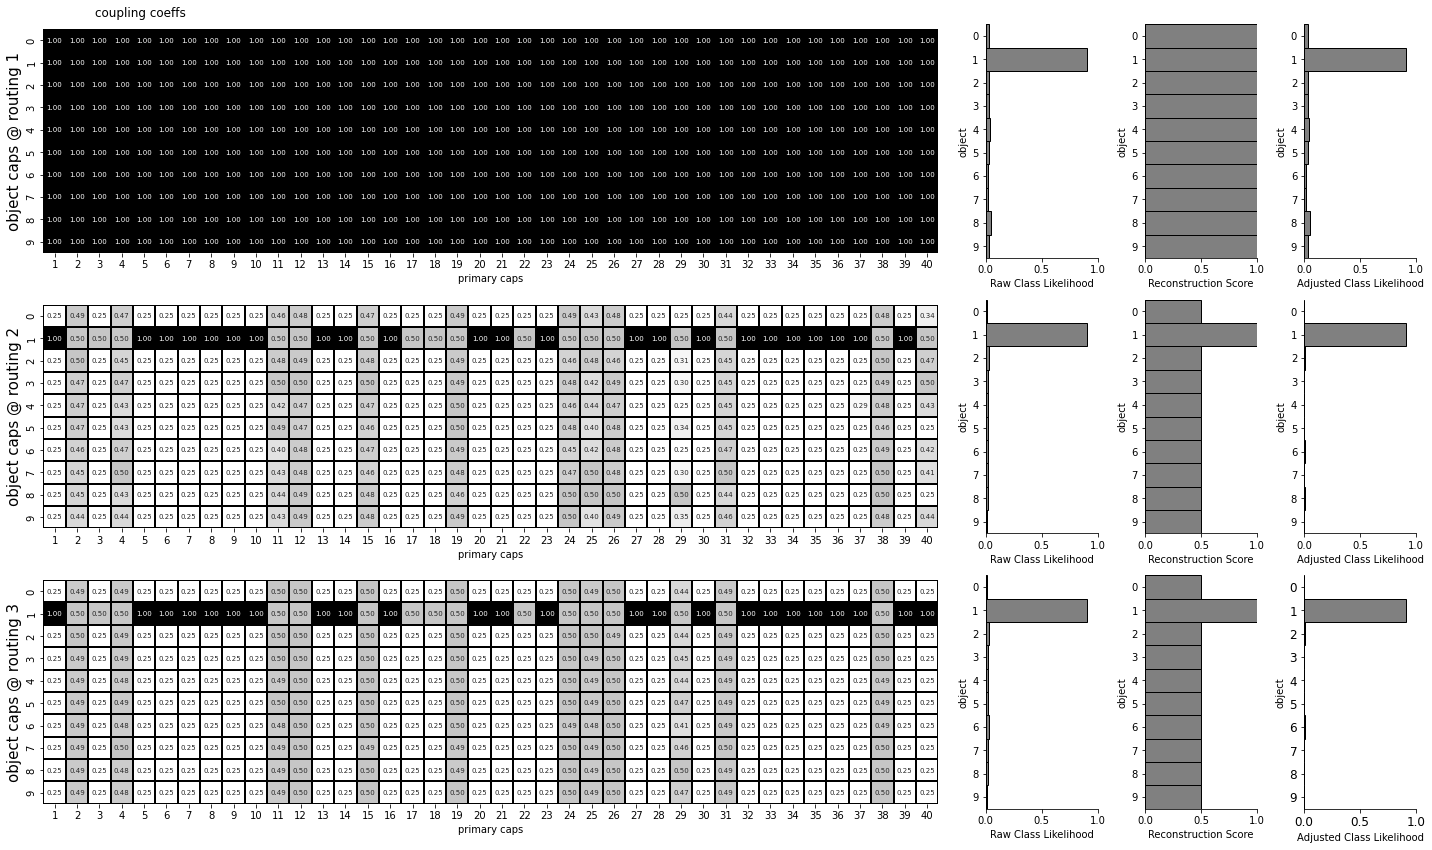



================ TRIAL 336 ===================


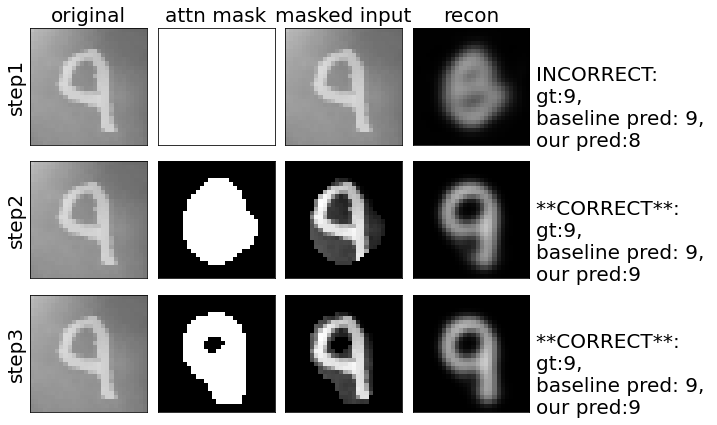

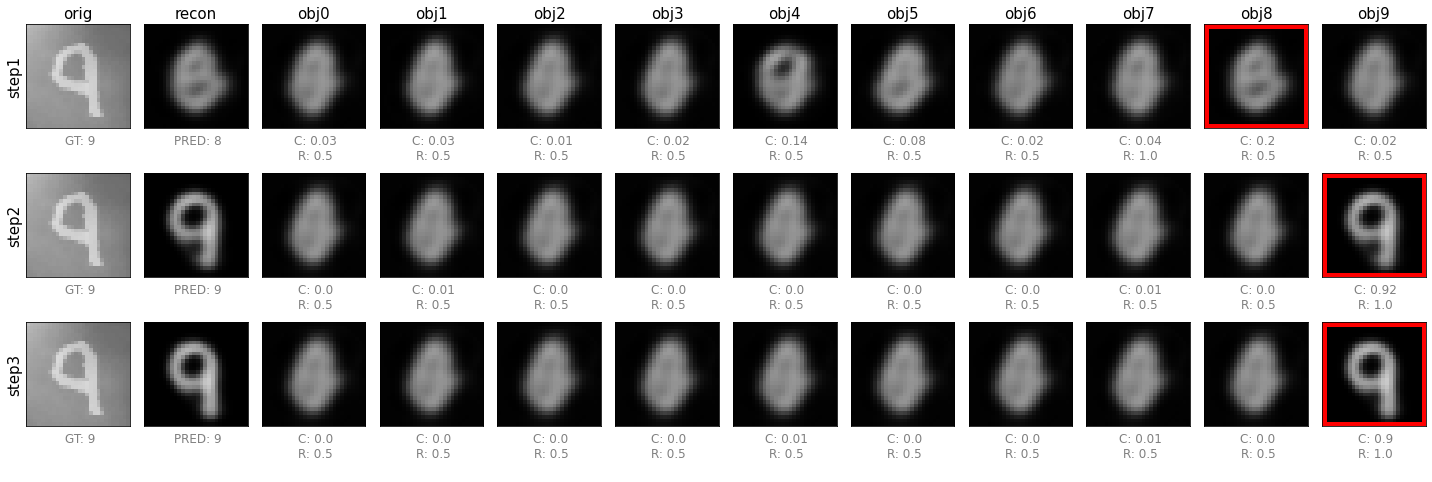

coupling coeff at time step:  1
self.rc===


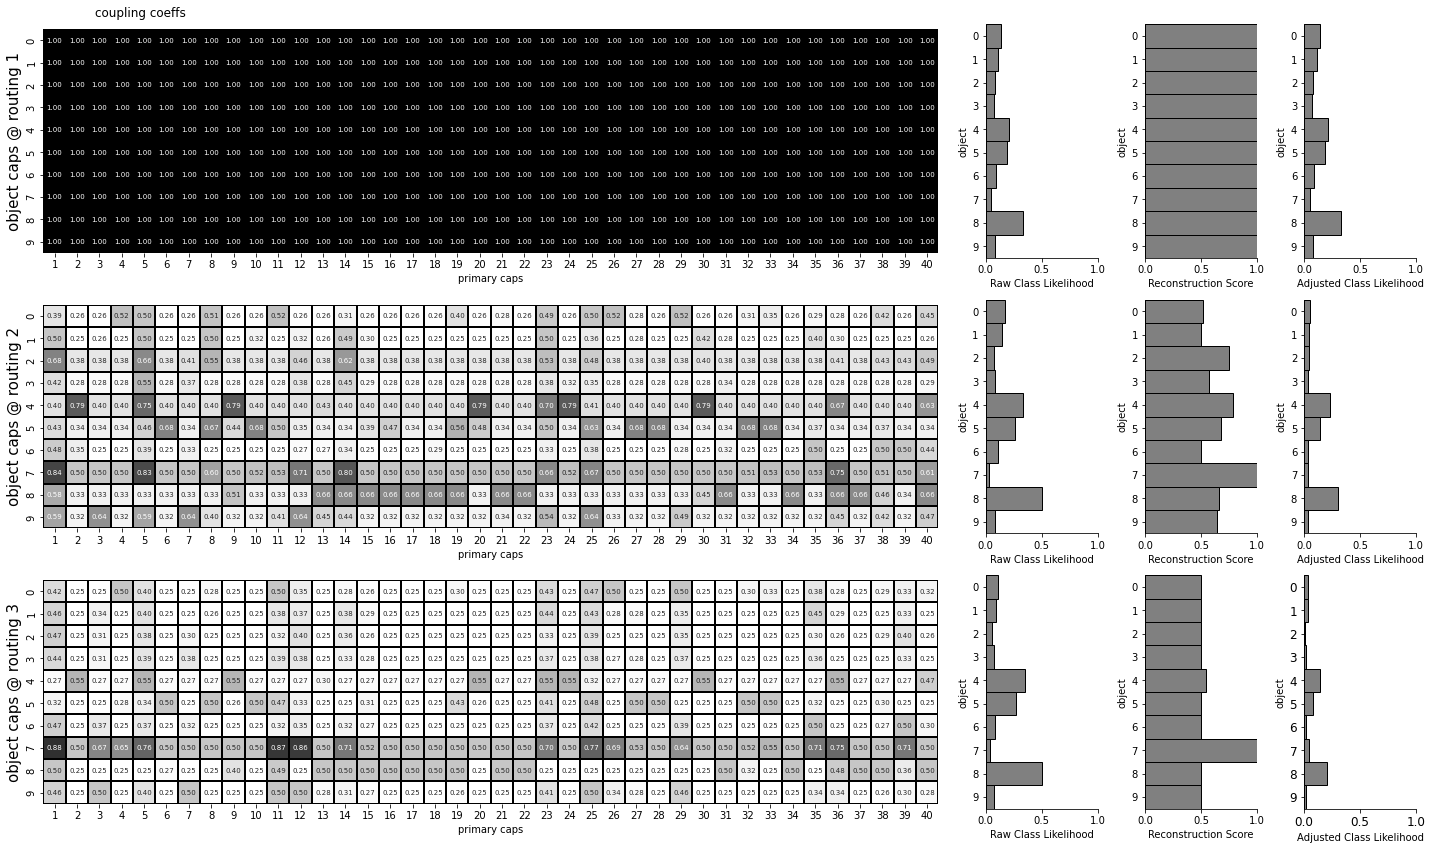

coupling coeff at time step:  2
self.rc===


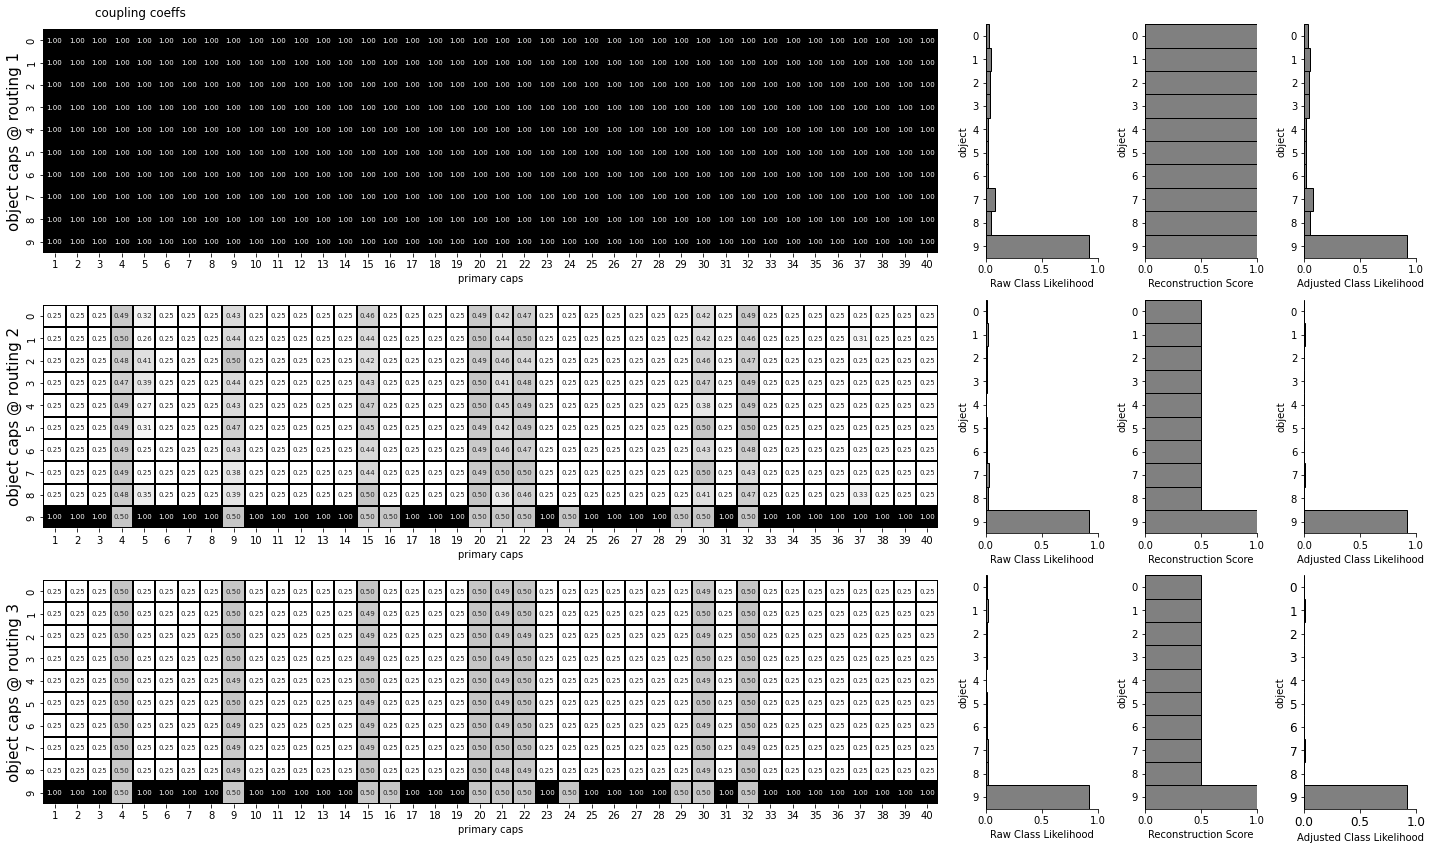

coupling coeff at time step:  3
self.rc===


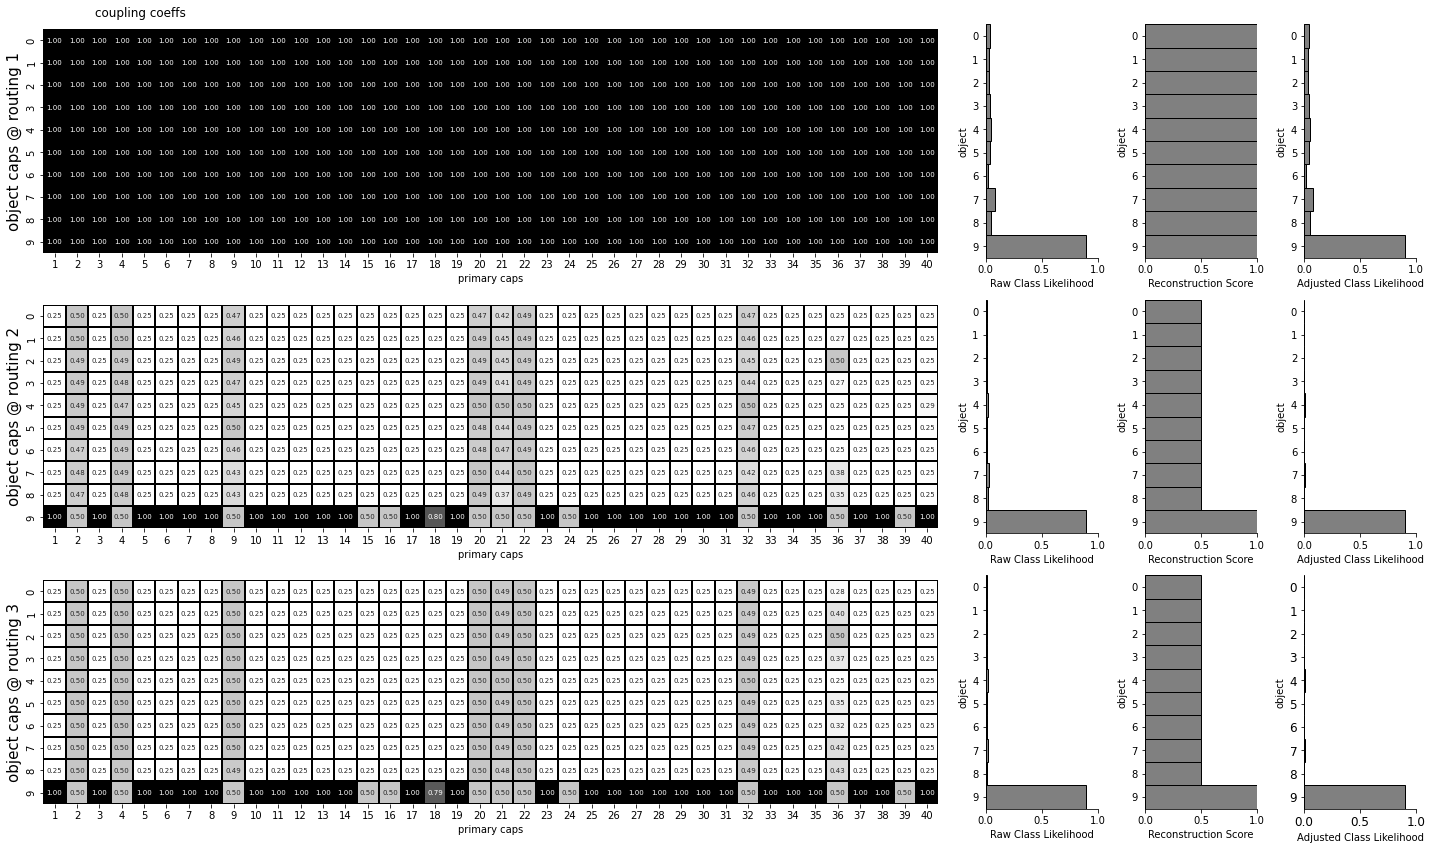



 FINISED. There are 2 images plotted


[329, 336]

In [203]:
#############################
# test a single model, and visualize outputs
#############################
task='mnist_c_mini'
task='mnist_recon'
task='mnist_c_original'

train=False #train or test dataset
print_args=False

# load model 
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 
                 'time_steps': 4, 'routings': 3, 'mask_threshold': 0.1}

load_model_path = './results/mnist/May29_2045_blur_res4_run1/best_epoch32_acc1.0000.pt'

args = load_args(load_model_path, args_to_update, print_args)
model = load_model(args)


# obtain model prediction and outputs
# corruption_index =2
corruption =CORRUPTION_TYPES[corruption_index-1]

if task == 'mnist_c_mini':
    x, gtx, y_hot, acc_model, objcaps_len_step, x_recon_step, outputs_model  = \
    evaluate_model_on_mnistc_mini(corruption, model, args, train, verbose=False, save_hooks=True, max_batch_num=None)
    print(f'==> corruption type: {corruption}, this batch acc: {acc_model.mean().item()}')
elif task =='mnist_c_original':
    print("original is used")
    batchnum=0
    x, gtx, y_hot, acc_model, objcaps_len_step, x_recon_step, outputs_model = \
    evaluate_model_on_mnistc_original(corruption, model, verbose=False, save_hooks=True, max_batch_num=batchnum)
    print(f'==> corruption type: {corruption}, this batch acc: {acc_model.mean().item()}')
else:
#     batchnum=corruption_index*int(1000/BATCHSIZE)-1
    x, gtx, y, objcaps_len_step, x_recon_step, outputs_model = evaluate_on_batch(task, 1, model, args, train)

# get model prediction
objcaps_len_step_narrow = objcaps_len_step.narrow(dim=2,start=0, length=args.num_classes)
# pred_model = objcaps_len_step_narrow.max(dim=-1)[1][:,-1] #torch.Size([1000, 3])


def get_nstep(objcaps_len_step_narrow, y_hot):
    def get_first_zero_index(x, axis=1):
        cond = (x == 0)
        return ((cond.cumsum(axis) == 1) & cond).max(axis, keepdim=True)[1]

    pstep = objcaps_len_step_narrow.max(dim=-1)[1]
    pnow = pstep[:,1:]
    pbefore = pstep[:,:-1]

    pdiff = (pnow-pbefore)
    null_column = -99*torch.ones(pdiff.size(0),1).to(pdiff.device)
    pdiff = torch.cat([null_column, pdiff], dim=1)
    pdiff[:,-1]=0
    nstep = get_first_zero_index(pdiff)
    pred_model= torch.gather(pstep, 1, nstep).flatten()
    acc_model = torch.eq(pred_model.cpu(), y_hot.max(dim=1)[1])
    return (nstep.flatten()+1).cpu().numpy(), pred_model, acc_model

nstep, pred_model, acc_model_check = get_nstep(objcaps_len_step_narrow, y_hot)
assert round(acc_model.mean().item(), 4) == round(acc_model_check.float().mean().item(), 4)
# routing
###################################
# stepwise visualization
###################################
idx_start = 0 # can't be higher than batchsize
n_image =500



condition = 'first correct last incorrect'
condition = 'first incorrect last correct'
# condition = 'first incorrect last incorrect'
condition = 'all'
# condition = 'correct'
condition = 'incorrect' 

condition = idx_plotted
visualize_detail(model, x.to(DEVICE), y_hot, outputs_model, 
                 x_recon_step, objcaps_len_step, args,
                 start=idx_start, n_image=n_image, plot_trials_when = condition,
                 plot_routings=True, 
                 pred_to_compare=pred_cnn, num_steps_to_finish=list(nstep), 
                 only_plot_object=None)

# Visualization in batch

In [ ]:
#################################
# if you need separate visualization for each output 
##################################
idx_start = 40 # can't be higher than batchsize
n_image =10

print("\n\n=========================== reconstruction =================================")
visualize_batch(x, y, x_recon_step, objcaps_len_step, include_sum=False, start=idx_start, n_image=n_image)

print("\n\n=========================== reconstruction mask =================================")
visualize_batch(x, y, outputs['x_mask'], objcaps_len_step, start=idx_start, n_image=n_image)

print("\n\n=========================== masked input =================================")
visualize_batch(x, y, outputs['x_input'], objcaps_len_step, start=idx_start, n_image=n_image)

In [ ]:
# # plot and save image outputs
# from torchvision.utils import save_image, make_grid
# import matplotlib.pyplot as plt

# n_image = 50
# plot_save_dir = None
# img_grid = torch.cat((x[:n_image].to(args.device),torch.sum(x_recon_step,dim=1)[:n_image]))
# img_grid = make_grid(img_grid, nrow=10, padding=1, normalize=False, pad_value=1)

# if plot_save_dir:
#     model_name = args.log_dir.split('/')[-1]
#     save_name = f'final_reconstruction_{model_name}.png'
#     save_image(img_grid, os.path.join(plot_save_dir, save_name))

# # img_g = Image.open(os.path.join(args.output_dir, save_name))
# # f = plt.figure()
# # f.set_figheight(15)
# # f.set_figwidth(15)
# plt.imshow(img_grid.cpu()[], cmap='gray_r') #matplot imshow() WILL AUTO CHANGE ONE CHANNEL IMG TO COLOR ONE
# plt.show()

# def show_reconstruction(model, test_loader, n_images, args):
#     import matplotlib.pyplot as plt
#     from utils import combine_images
#     from PIL import Image
#     import numpy as np

#     model.eval()
#     for x, _ in test_loader:
#         x = Variable(x[:min(n_images, x.size(0))].cuda(), volatile=True)
#         _, x_recon = model(x)
#         data = np.concatenate([x.data, x_recon.data])
#         img = combine_images(np.transpose(data, [0, 2, 3, 1]))
#         image = img * 255
#         Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
#         print()
#         print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
#         print('-' * 70)
#         plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png", ))
#         plt.show()
#         break
        
# # https://medium.com/@sergioalves94/deep-learning-in-pytorch-with-cifar-10-dataset-858b504a6b54
# from torchvision.utils import make_grid

# for images, _ in train_loader:
#     print('images.shape:', images.shape)
#     plt.figure(figsize=(16,8))
#     plt.axis('off')
#     plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
#     break